In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

In [2]:
df = pd.read_csv('avg_salary.csv')

## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Period     48 non-null     float64
 1   Seniority  48 non-null     object 
 2   Salary     48 non-null     float64
 3   GDP        48 non-null     float64
dtypes: float64(3), object(1)
memory usage: 1.6+ KB


In [4]:
df.head()

,Period,Seniority,Salary,GDP
0,2019.06,Junior,921.362637,3619.861572
1,2019.06,Lead,2941.538462,3619.861572
2,2019.06,Middle,1968.099099,3619.861572
3,2019.06,Senior,2371.913043,3619.861572
4,2019.12,Junior,1004.463768,3619.861572


In [5]:
df.dtypes

Period       float64
Seniority     object
Salary       float64
GDP          float64
dtype: object

In [6]:
df.shape

(48, 4)

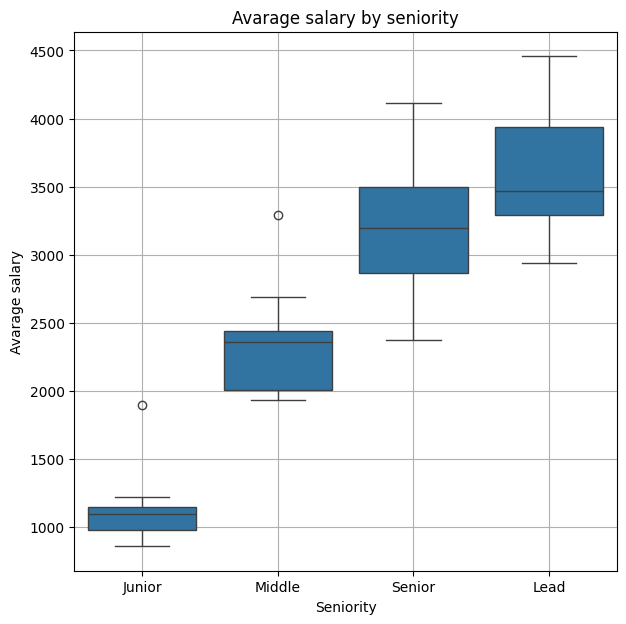

In [7]:
plt.figure(figsize=(7, 7))
sns.boxplot(df, x='Seniority', y = 'Salary', order = df.groupby('Seniority')['Salary'].mean().sort_values().index)
plt.title('Avarage salary by seniority')
plt.ylabel('Avarage salary')
plt.grid()
plt.show()

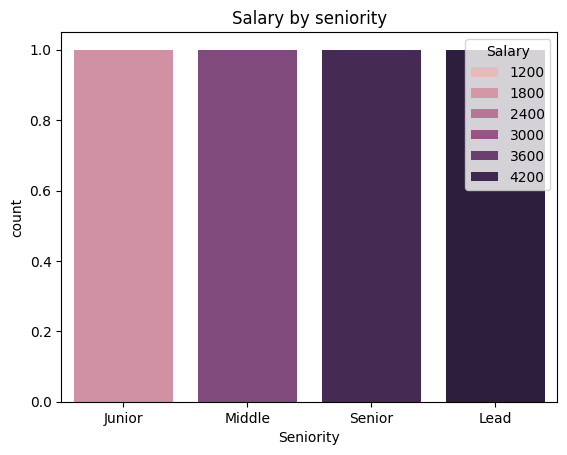

In [8]:
sns.countplot(x = df['Seniority'], hue = df['Salary'], dodge = False, order = df.groupby('Seniority')['Salary'].mean().sort_values().index, saturation = 1.5)
plt.title('Salary by seniority')
plt.show()

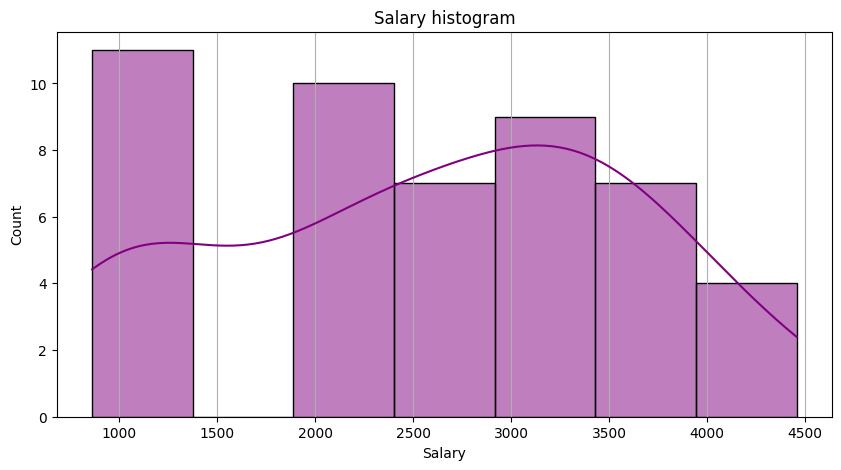

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Salary'], bins = 'auto', kde= True, color = 'purple', edgecolor = 'black')
plt.title('Salary histogram')
plt.grid(axis = 'x')
plt.show()

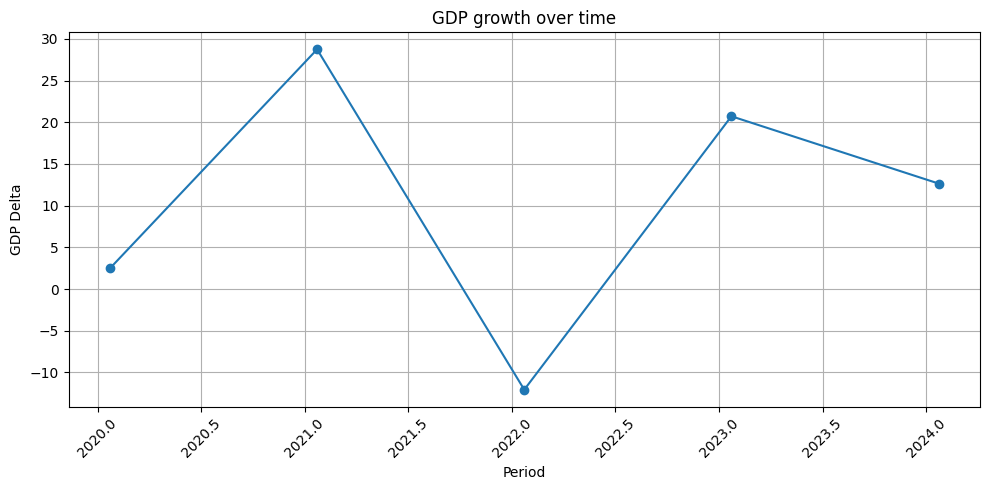

In [10]:
df_gdp = df[['Period', 'GDP']].drop_duplicates().sort_values('Period')
df_gdp = df_gdp[df_gdp['Period'].astype(str).str.endswith('.06')]
df_gdp['GDP Delta%'] = df_gdp['GDP'].pct_change() * 100
plt.figure(figsize=(10, 5))
plt.plot(df_gdp['Period'], df_gdp['GDP Delta%'], marker = 'o', linestyle = '-')
plt.title('GDP growth over time')
plt.xlabel('Period')
plt.ylabel('GDP Delta')
plt.xticks(rotation = 45)
plt.grid()
plt.tight_layout()
plt.show()

### Differentation

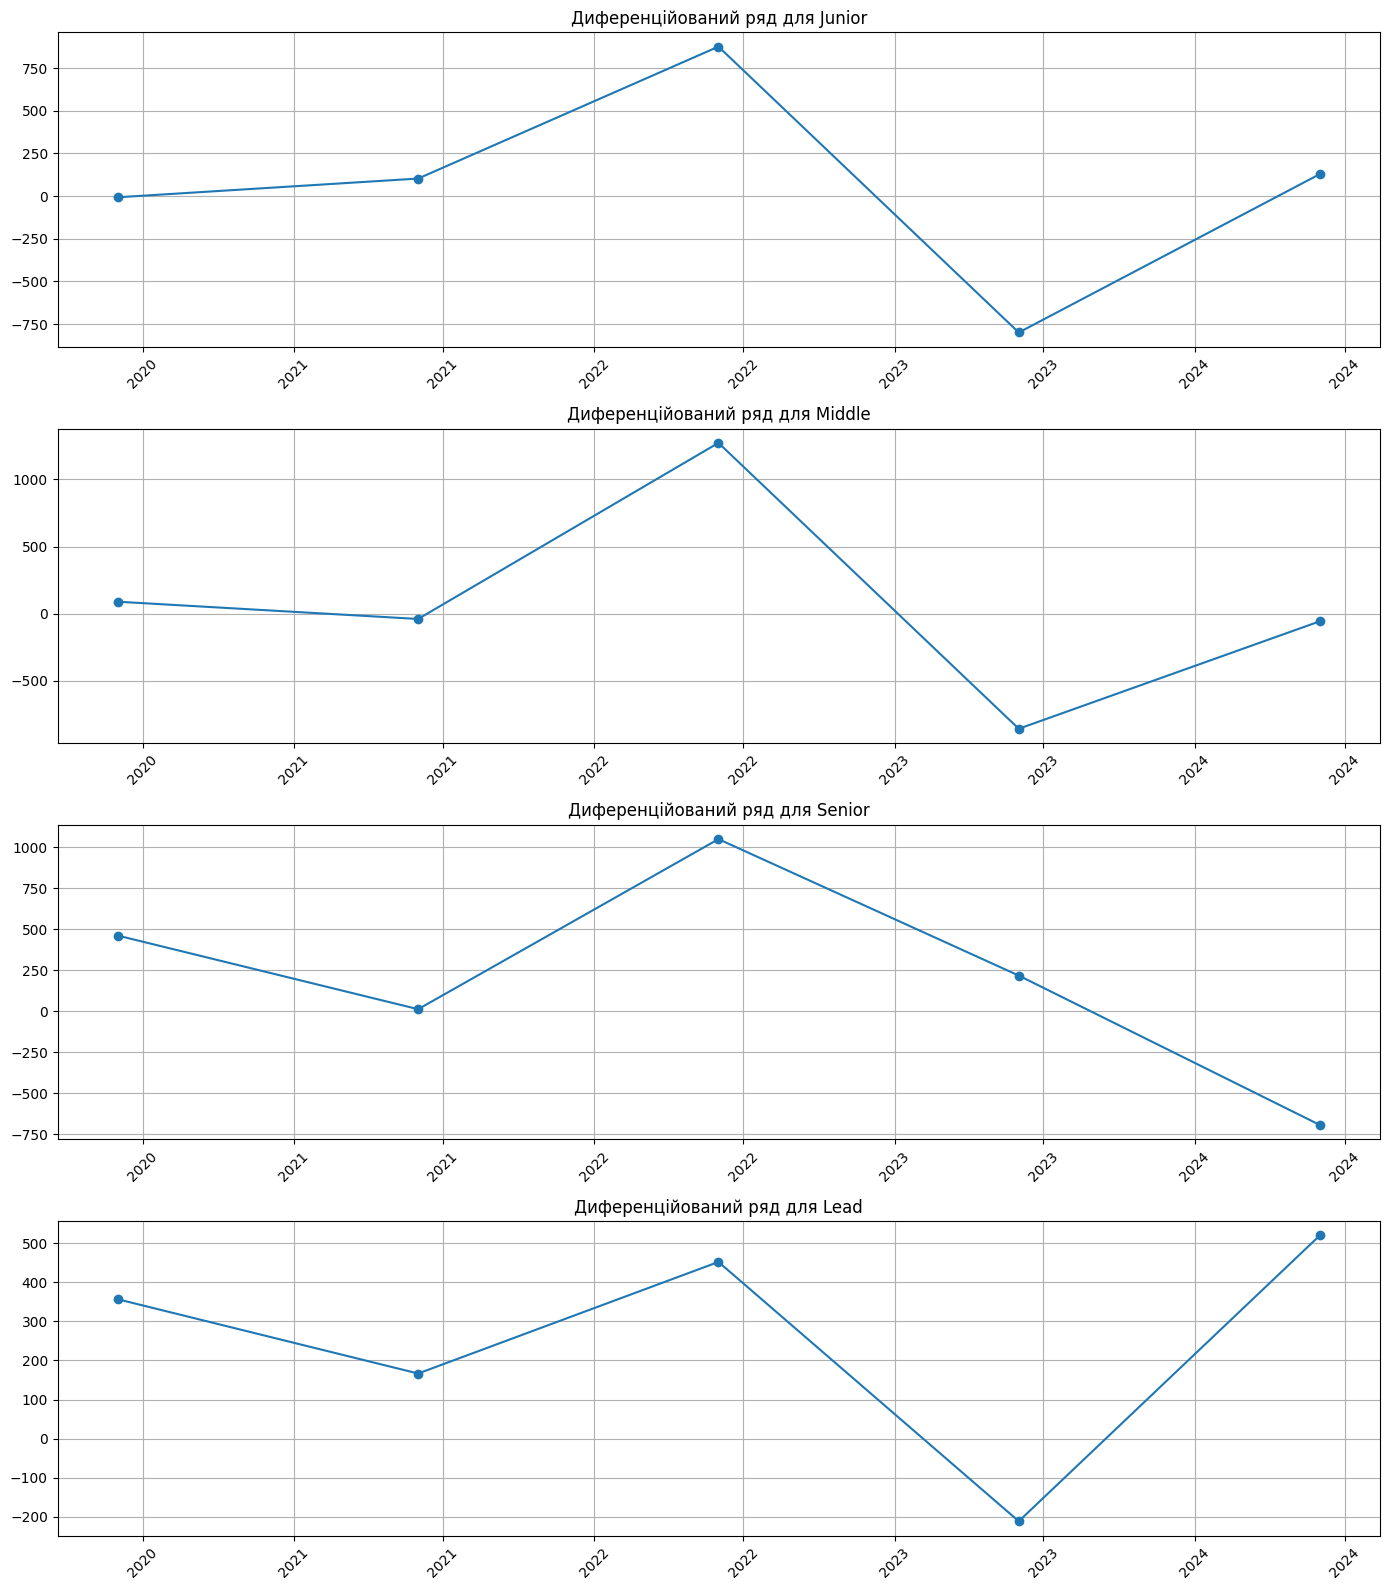

In [19]:
order = ['Junior', 'Middle', 'Senior', 'Lead']
unique_sen = [x for x in order if x in df['Seniority'].unique()]

plt.figure(figsize=(14, 4 * len(unique_sen)))

for i, level in enumerate(unique_sen, start=1):
    subset = df[(df['Seniority'] == level) & ((df['Period'] % 1).round(2) == 0.06)].copy()
    subset['Period_str'] = subset['Period'].apply(lambda x: f"{int(x)}.{int(round((x - int(x)) * 100)):02d}")
    subset['Period_dt'] = pd.to_datetime(subset['Period_str'], format='%Y.%m')
    d_series = subset['Salary'].diff().dropna()
    periods = subset['Period_dt'].iloc[1:]

    plt.subplot(len(unique_sen), 1, i)
    plt.plot(periods, d_series, marker='o')
    plt.title(f'Диференційований ряд для {level}')
    plt.grid()

    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Decomposition

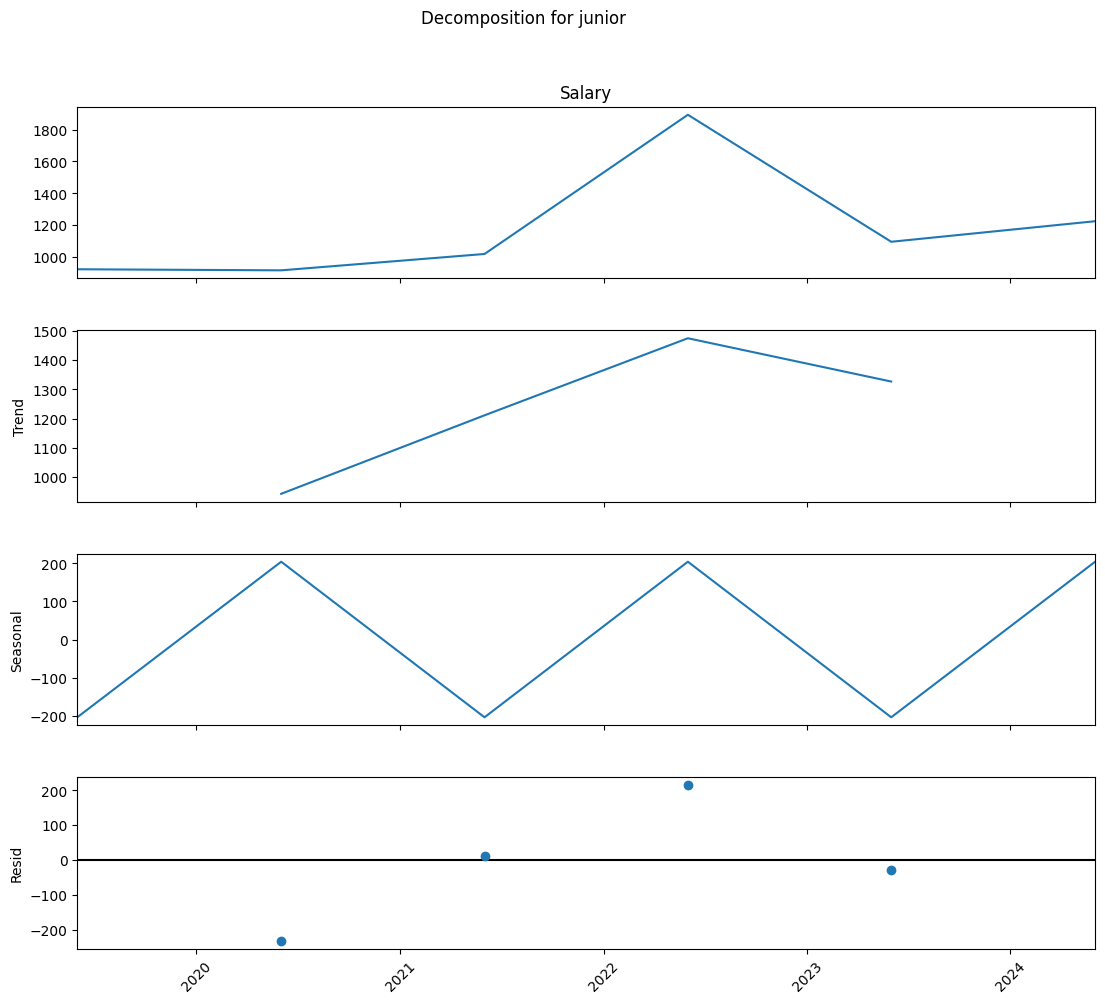

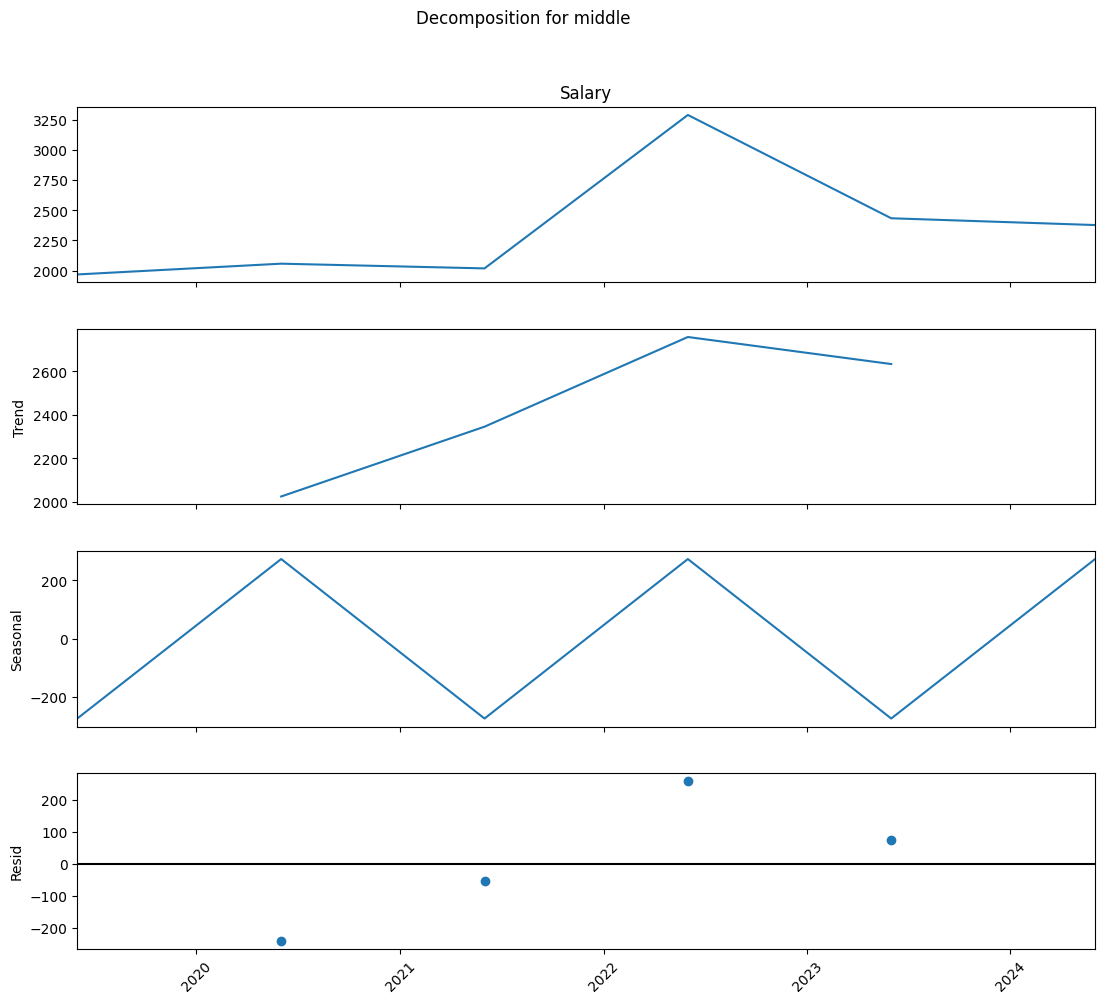

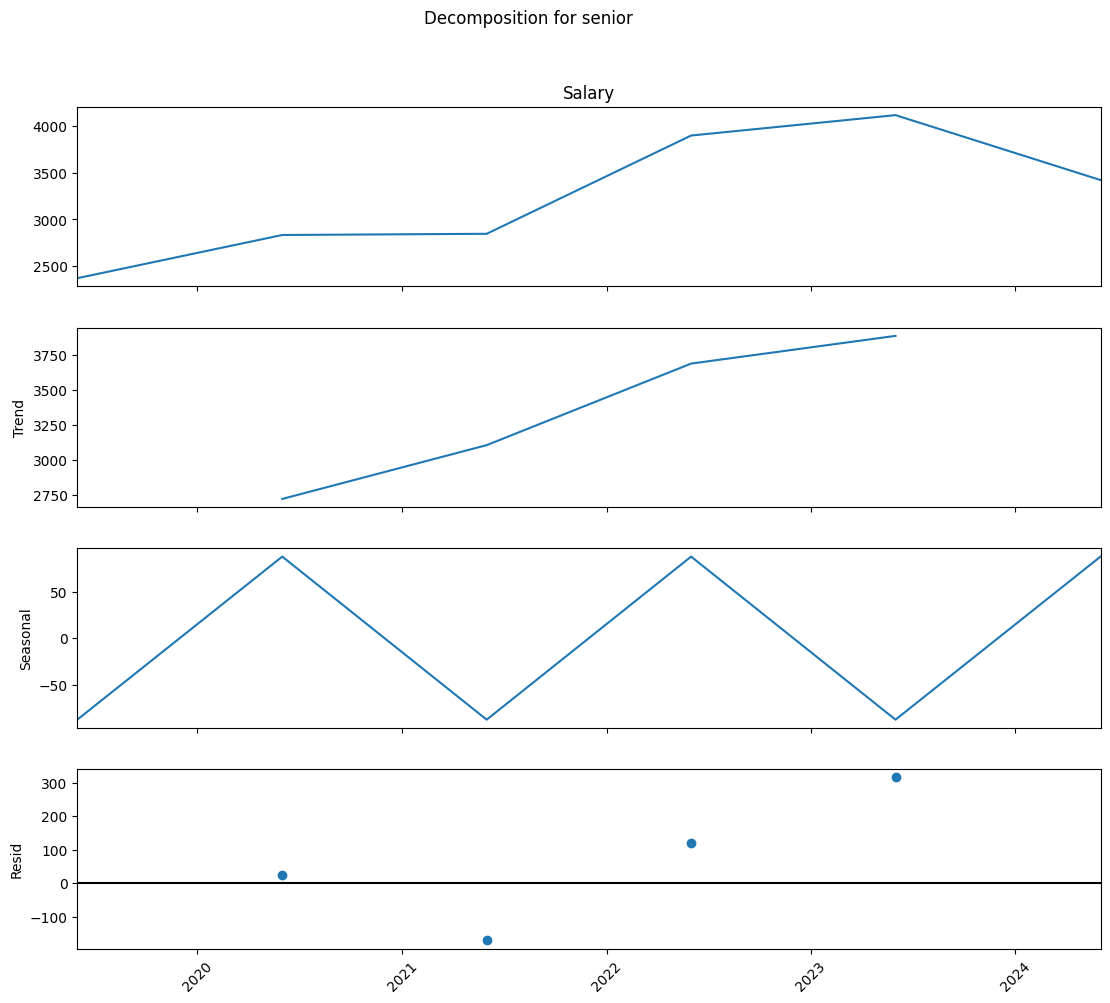

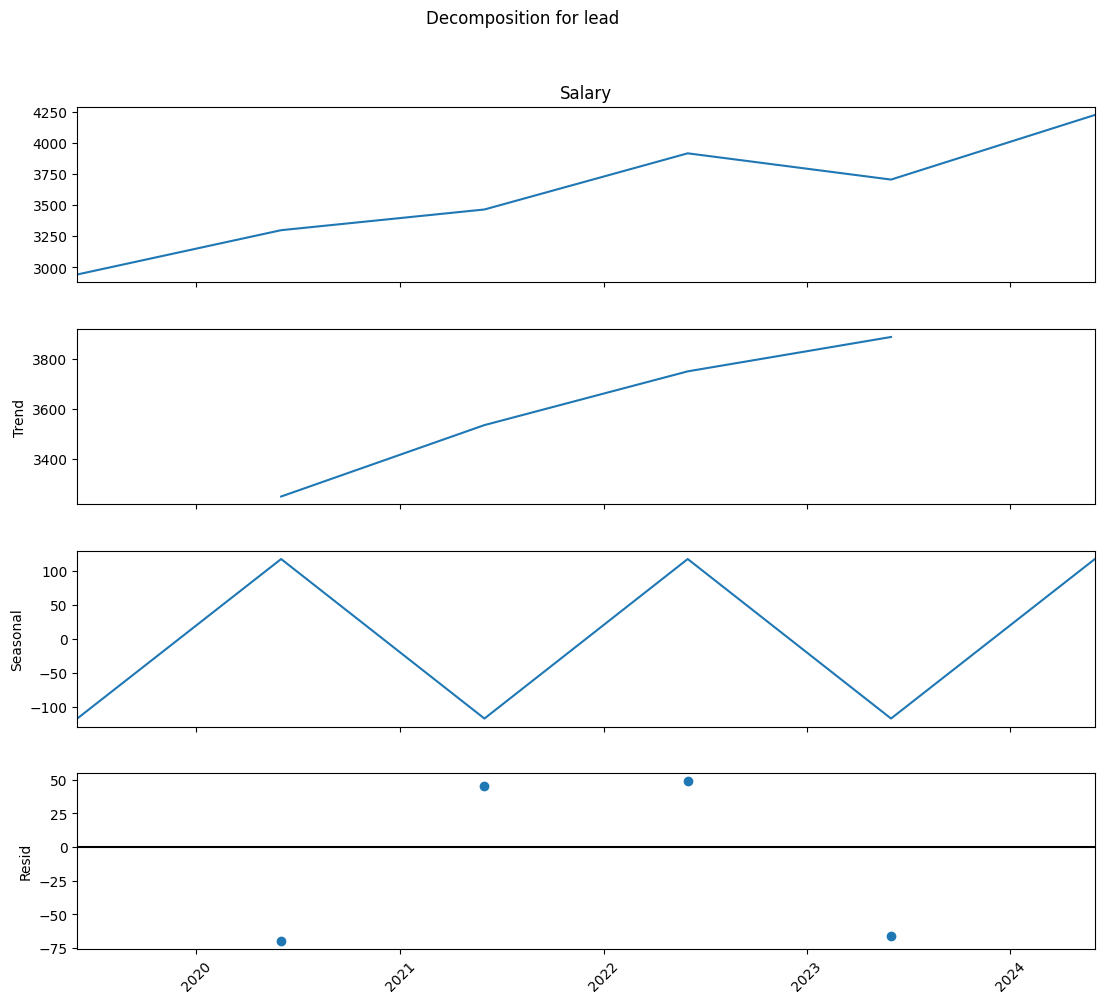

In [22]:
df['Seniority'] = df['Seniority'].str.strip().str.lower()

order = ['junior', 'middle', 'senior', 'lead']
unique_sen = [x for x in order if x in df['Seniority'].unique()]

for level in unique_sen:
    subset = df[(df['Seniority'] == level) & ((df['Period'] % 1).round(2) == 0.06)].copy()
    subset['Period_str'] = subset['Period'].apply(lambda x: f"{int(x)}.{int(round((x - int(x)) * 100)):02d}")
    subset['Period_dt'] = pd.to_datetime(subset['Period_str'], format='%Y.%m')
    subset.set_index('Period_dt', inplace=True)

    s_s = subset['Salary']

    decompose = seasonal_decompose(s_s, model='additive', period=2)

    fig = decompose.plot()
    fig.set_size_inches(12, 10)
    plt.suptitle(f'Decomposition for {level}', y=1.02)
    plt.xticks(rotation=45)
    plt.show()
